# Paperspace Stable Diffusion Notebook

This Notebook contains instructions and easy steps for generating images with Stable Diffusion on any of Paperspace's GPUs with little set up required. Follow the instructions in the markdown cells in this Notebook to quickly launch the Stable Diffusion Web UI or begin generating images using the Diffusers Stable Diffusion Pipeline.

Contents:

- Use the Stable Diffusion Web UI
    - Loading in the Stable Diffusion models for the Web UI with support for v1-5 and v2 models
- The Diffusers Stable Diffusion Pipeline
    - Loading in the Stable Diffusion models for the Diffusers StableDiffusionPipeline with support for v1-4, v1-5 and v2 models
    - Access additional models: log in to HuggingFace for online access model files
    - Inference with the Diffusers pipeline
- CLIP reranking
- GFPGAN face restoration and image upscaling
- CodeFormer face restoration and image upscaling

## Setup

First, run the cell below to get everything we need for this Notebook to run.

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git 
!pip install -U transformers accelerate scipy
!pip install flax==0.5.0 --no-deps
!pip install msgpack rich optax accelerate ftfy scipy
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!git clone https://github.com/AUTOMATIC1111/stable-diffusion-webui
!mkdir outputs
!pip uninstall -y torch torchvision torchaudio
!pip3 install torch torchvision torchaudio --no-cache-dir --index-url https://download.pytorch.org/whl/cu118


## Use the Stable Diffusion Web UI

Run the cell below to setup, and launch the Automatic1111 Stable Diffusion Web UI from this notebook. Click the Gradio link after the setup completes to access the Web UI in your local browser. 

Skip this step to use the Diffusers library methodology.

### Loading in the Stable Diffusion models for the Web UI 

To make accessing the Stable Diffusion models easy and not take up any storage, we have added the Stable Diffusion v1-5 and v2 models as mountable public datasets!

> These files will not count towards the storage limit for free notebooks.

To access the model files:

First, navigate to the "Data Sources" tab using the navigator on the far left of the page.

Next, click "Public" to switch into the Gradient Public Datasets, and scroll down until you find the Stable Diffusion datasets near the bottom of the list. You can mount `stable-diffusion-classic` for access to the v1-5 model checkpoints for the web UI, `stable-diffusion-diffusers` for the v1-5 models as Diffusers StableDiffusionPipeline binaries, `stable-diffusion-classic-v2` for access to the v2 model checkpoints and config file for use with the web UI, and `stable-diffusion-diffusers-v2` for access to the v2 models as Diffusers StableDiffusionPipeline binaries.

Finally, click "mount" to make any of these Public Datasets accessible from the "datasets" directory. This directory is in the root folder, so access it with the path `~/../datasets/stable-diffusion-classic/SDv1.5.ckpt`. For example, after mounting, the v1-5 checkpoint can be found at `~/../datasets/stable-diffusion-classic/SDv1.5.ckpt`

See the video below for a video guide to for help mounting these files. 


In [ ]:
# Launch the Stable Diffusion Web UI. 
# Be sure to hash out whichever you are not using.
%cd stable-diffusion-webui

## Launch Web UI for Stable Diffusion v2 models. Note: this prevents users from using checkpoints and embeddings trained on v1-X models.
!python launch.py --share --config ~/../datasets/stable-diffusion-classic-v2/768-v-ema.yaml --ckpt ~/../datasets/stable-diffusion-classic-v2/768-v-ema.ckpt

## Launch Web UI for Stable Diffusion v1-x models.
!python launch.py --share --ckpt ../../datasets/stable-diffusion-classic/SDv1.5.ckpt


# The Diffusers Stable Diffusion Pipeline

## Loading in the Stable Diffusion v1-5 and v2 models for the Diffusers StableDiffusionPipeline

To make accessing the Stable Diffusion models easy and not take up any storage, we have added the Stable Diffusion models as mountable public datasets! To access the models this way, simply navigate to the "Data Sources" tab using the navigator on the far left of the page. 

Then click "Public" to switch into the Gradient Public Datasets, and scroll down until you find the datasets starting with "stable-diffusion" near the bottom of the list. We recommend mounting each of these public datasets: `stable-diffusion-classic` (v1-5 checkpoint), `stable-diffusion-diffusers` (v1-5 diffusers), `stable-diffusion-classic-v2` (v2 checkpoint & config), and `stable-diffusion-diffusers-v2` (v2 diffusers). 

Click "mount" to make each of them accessible from the "datasets" directory. This directory is in the root folder, so access the two directories with the paths `~/../datasets/` and `../datasets/stable-diffusion-diffusers-v2/stable-diffusion-2/`

<video controls src="assets/stab-upload.mp4" />


## Access additional models: log in to HuggingFace for online access to v1-4 and v2 model files

In order to access the models from CompVis for Stable Diffusion, you must follow three steps:

1. You must acknowledge and agree to their user requirements and license for their models. You can do so by reading the instructions found on these pages: 
- [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- [RunwayML/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
- [StabilityAI/stable-diffusion-2](https://huggingface.co/stabilityai/stable-diffusion-2) 

2. You must login to Huggingface, and then create and retrieve an access token (found here: https://huggingface.co/settings/tokens)

3. Finally, replace the segment of the cell below `<your_huggingface_token>` with your own token, and run the cell. 

If you follow these steps, you will be able to access the model for free!



In [2]:
!python login.py --token <your_huggingface_token>

## Inference with the Diffusers pipeline

Use the following cells to begin synthesizing images. Use the radio buttons in the cell below to select which model type to use. 

### Setup

Use the following cell to set up your inference by

- Choose which Stable Diffusion checkpoint to use
- Creating the outputs directory
- Choose whether to use FP16 or FP32 (use FP16 for Free-GPU Notebooks)
- import packages

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import ipywidgets as widgets
from ipywidgets import interact

%cd ~/../notebooks

## Use the lists below to select our model type, image output resolution, and the computer number format for inference
device = 'cuda'
## We recommend either v1-5 (index 1) or v2 (index 2)
model_id = ['CompVis/stable-diffusion-v1-4',"../datasets/stable-diffusion-diffusers/stable-diffusion-v1-5/",'../datasets/stable-diffusion-diffusers-v2/stable-diffusion-2/']
## We strongly recommend using the v1-5 and v1-4 models with size 512, and the v2 models with size 768.
size = [512, 768]
## If you are using a GPU with ~ 8 GBs of RAM, like the Free-GPU Notebooks, then use torch.float16
## otherwise, either selection works
dtype = [torch.float16, torch.float32]


# Set your values here - defaults are for v2, size 768 x 768 with FP16 computer number format
model_ = model_id[2]
size_ = size[1] 
precision = dtype[0]

In [28]:
# Depending on the selections made above, the type of model loaded will change using this short if/else statement

print(f'Now loading Stable Diffusion {model_} model ({precision})...')
scheduler = EulerDiscreteScheduler.from_pretrained('stabilityai/stable-diffusion-2', subfolder="scheduler")
if precision == torch.float16:
    if model_ == '../datasets/stable-diffusion-diffusers-v2/stable-diffusion-2/':
        pipe = StableDiffusionPipeline.from_pretrained(model_, torch_dtype=torch.float16, revision="fp16", scheduler = scheduler)
        pipe = pipe.to(device)
    else:
        pipe = StableDiffusionPipeline.from_pretrained(model_, torch_dtype=torch.float16, revision="fp16")
        pipe = pipe.to(device)
else:
    if model_ == '../datasets/stable-diffusion-diffusers-v2/stable-diffusion-2/':
        pipe = StableDiffusionPipeline.from_pretrained(model_, scheduler = scheduler)
        pipe = pipe.to(device)
    else:
        pipe = StableDiffusionPipeline.from_pretrained(model_)
        pipe = pipe.to(device)
print('Model now loaded. Head to next cell to generate images.')

Now loading Stable Diffusion v1-5 model (FP32)...
Model now loaded. Head to next cell to generate images.


Generating samples from Stable Diffusion v1-5 checkpoint (FP32)


  0%|          | 0/50 [00:00<?, ?it/s]

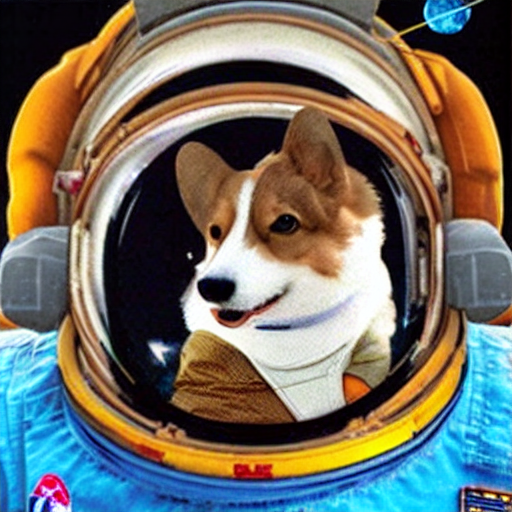

  0%|          | 0/50 [00:00<?, ?it/s]

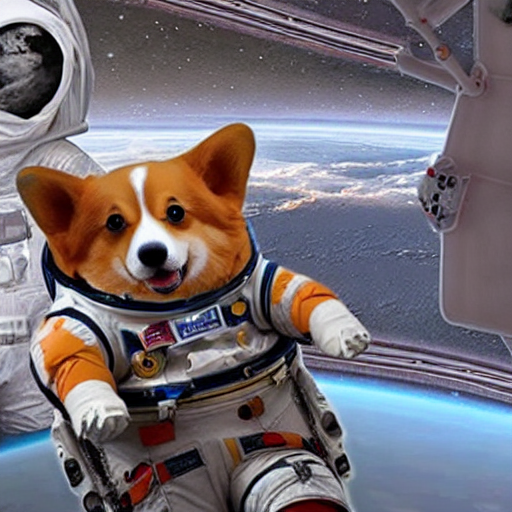

  0%|          | 0/50 [00:00<?, ?it/s]

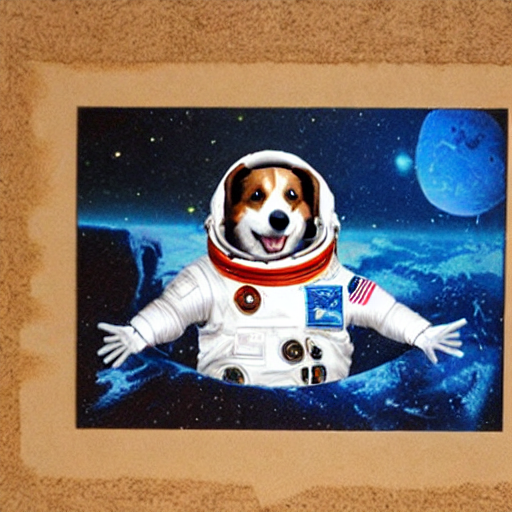

  0%|          | 0/50 [00:00<?, ?it/s]

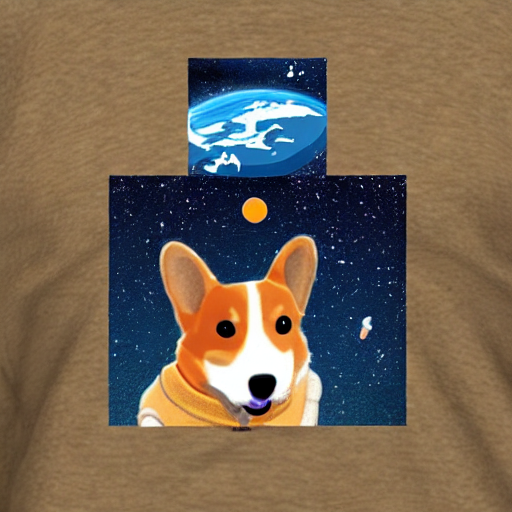

  0%|          | 0/50 [00:00<?, ?it/s]

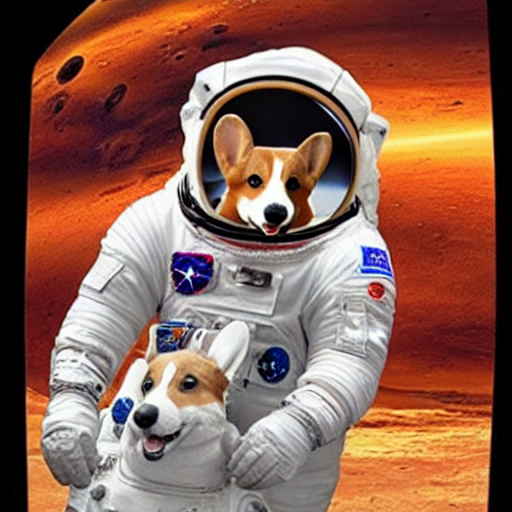

In [29]:
sample_num = 5
lst = []

print(f'Generating samples from Stable Diffusion {model_} checkpoint ({precision})')

prompt = 'a corgi astronaut on mars'
for j in range(sample_num):
    a = pipe(prompt,
             guidance_scale=7.5,
             height = size_,
             width = size_,
             num_inference_steps=50)['images'][0]
    lst.append(a)
    display(a)
    a.save(f'outputs/gen-image-{j}.png')

# CLIP reranking

Find the best of your images from the generated samples by ranking them with CLIP by their accuracy to the prompt. 

Code adapted from Boris Dayma's [DALL-E Mini Inference Pipeline](https://github.com/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb) 

In [ ]:
from transformers import CLIPProcessor, FlaxCLIPModel
import jax
import jax.numpy as jnp
from flax.jax_utils import replicate
from functools import partial


# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [6]:
from flax.training.common_utils import shard
import numpy as np
# get clip scores
clip_inputs = clip_processor(
    text=prompt * jax.device_count(),
    images=lst,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

out = list(reversed(sorted(zip(logits[0], lst))))

In [ ]:
for idx, v in enumerate(out):
    display(v[1])
    print(f"Score: {v[0][0]:.2f}\n")
    


# GFPGAN

GFPGAN aims at developing a Practical Algorithm for Real-world Face Restoration. It leverages rich and diverse priors encapsulated in a pretrained face GAN (e.g., StyleGAN2) for blind face restoration. GFPGAN is combined with a suite of other restoration and upscaling models to help make your pictures much clearer and cleaner. 

credit to: https://github.com/TencentARC/GFPGAN

In [ ]:
!git clone https://github.com/TencentARC/GFPGAN.git

%cd GFPGAN
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib

!pip install - r requirements.txt
!python setup.py develop
!pip install realesrgan basicsr optax

# If you want to enhance the background (non-face) regions with Real-ESRGAN,
# you also need to install the realesrgan package
!pip install realesrgan

# get model
%cd GFPGAN/experiments/pretrained_models
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth
%cd ~/../notebooks

In [ ]:
%cd GFPGAN
!python inference_gfpgan.py -i ../outputs -o results -v 1.3 -s 2
%cd ~/../notebooks


# CodeFormer

'Transformer-based prediction network, named CodeFormer, to model global composition and context of the low-quality faces for code prediction, enabling the discovery of natural faces that closely approximate the target faces even when the inputs are severely degraded.' - Project credit to [Source](https://shangchenzhou.com/projects/CodeFormer/)

This alternative to GFPGAN also does a great job of upscaling images. Much like above, you can run the next two cells to upscale the full images from our outputs directory.


In [ ]:
# Install and setup
# git clone this repository
!git clone https://github.com/sczhou/CodeFormer
%cd CodeFormer
# install python dependencies
!pip install realesrgan basicsr optax lpips
!python scripts/download_pretrained_models.py facelib
!python scripts/download_pretrained_models.py CodeFormer
%cd ..

In [ ]:
%cd CodeFormer
!python inference_codeformer.py -w 0.7 --input_path ../outputs
%cd ..